In [5]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile as wave
from scipy.signal import argrelextrema as arg
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
import p398dlp_read_audio_function as RA

In [6]:
def getAudioMicros(filename):
	text = open(filename, 'r').read().split("\n")[3].split(',')

	hours = int(text[0])
	minutes = int(text[1])
	seconds = int(text[2])
	micros = int(text[3])

	microsInSec = 1e6
	microsInHour = 3600 * microsInSec
	microsInMin = 60 * microsInSec

	time = microsInHour * hours + microsInMin * minutes + microsInSec * seconds + micros

	return time

def adjustMicros(filename):
	time = open(filename, 'r').read().split("\n")
	time = [x for x in time if x != '']

	baseline = int(time[0])
	for t in range(len(time)):
		time[t] = int(time[t]) - baseline

	return time[1]

In [7]:
def plot(audiofile):
    #reads in the sample rate and data from the wave file as a buffer array
    #sampleRate, audio = wave.read(audiofile)
    data = RA.read_audio(audiofile, 50000000)
    #data = np.frombuffer(data, dtype=np.int16)[100:-100]

    #filter the peaks along the audio signal
    #peaks = find_peaks(data, height=np.mean(data)+6*np.std(data), distance=5000)[0]
    #print("the first peak is at", peaks[0]/32000, "seconds") # the first peak location

    #peaks_3 = find_peaks(data, height=np.mean(data)+40*np.std(data), distance=15000)[0]
    #print("the first peak_3 is at", peaks_3[0]/sampleRate, "seconds")

    #plots the audio signal
    plt.plot(data)
    #plots the peaks of signal_1
    #y = [data[i] for i in peaks]
    #plt.plot(peaks, y, 'ro',color='r')

    #plots the peaks of signal_3
    #y_3 = [data[i] for i in peaks_3] 
    #plt.plot(peaks_3,y_3,'ro',color='g')

    plt.ylabel("Amplitude")
    plt.xlabel("Samples")
    #plt.xlim([peaks[0]-10000, peaks[3]+10000])
    #plt.savefig('0.png')
    plt.show()
    return data

In [27]:
#####Plot functon with Chi-square calculation#####

def plot_shift(s, r, low_shift, high_shift, step):
    first_bin = max(-low_shift, 0)
    last_bin = min(min(len(r), len(s)) - high_shift - 1, min(len(r), len(s)))
    print(low_shift, high_shift, first_bin, last_bin)
    s = s.astype(float) - np.mean(s)
    r = r.astype(float) - np.mean(r)
    s_normalized = s / np.sqrt(np.std(s[first_bin: last_bin]))
    r_normalized = r / np.sqrt(np.std(r[first_bin: last_bin]))

    ###############################

    chisq_sum_min = 100000.
    chisq_sum_max = -100000.
    min_shift_chisq = 100000
    max_shift_chisq = -100000

    bin_shift_array = np.arange(low_shift, high_shift, step)
    normalized_chisq_array = np.empty(len(bin_shift_array))

    ijk = 0

    for bin_shift in range(low_shift, high_shift, step):

        chisq_sum = 0.0
        #print(bin_shift)

        for index in range(first_bin, last_bin):

            chisq_sum = chisq_sum + (s_normalized[index] - r_normalized[index + bin_shift]) ** 2 

        normalized_chisq = chisq_sum / (last_bin - first_bin + 1)

        normalized_chisq_array[ijk] = normalized_chisq
        ijk = ijk + 1

        if(normalized_chisq < chisq_sum_min):
            chisq_sum_min = normalized_chisq
            min_shift_chisq = bin_shift

        if(normalized_chisq > chisq_sum_max):
            chisq_sum_max = normalized_chisq
            max_shift_chisq = bin_shift

    print("min, max chisq: ", chisq_sum_min, chisq_sum_max)
    print("index shift for min, max: ", min_shift_chisq, max_shift_chisq)

    # plot stuff: sender, receiver 02
    plt.figure(figsize=(10,5))
    plt.plot(bin_shift_array, normalized_chisq_array)
    if len(bin_shift_array) < 100:
        plt.plot(bin_shift_array, normalized_chisq_array, 'r*')

    # set labels and title
    plt.xlabel("bin shift")
    plt.ylabel("normalized chisq value")
    the_title = "sender_04, receiver_04 data"
    plt.title(the_title) 
    plt.show()
    plt.close()
    return normalized_chisq_array, min_shift_chisq

def microStart(meta_send, meta_receive, audtxt_send, audtxt_receive, bin_shift, send_start, receive_start):
    sample_rate = 32000
    send_gps = getAudioMicros(meta_send) + adjustMicros(audtxt_send)
    receive_gps = getAudioMicros(meta_receive) + adjustMicros(audtxt_receive)
    print (receive_gps, send_gps)
    print (receive_gps - send_gps)
    return (receive_gps - send_gps) + (receive_start - send_start + bin_shift)/sample_rate*1e6

In [49]:
def chi_square(senderFile, receiverFile, meta_send, meta_receive, audtxt_send, audtxt_receive, s_start, r_start, length):
    s = plot(senderFile)[s_start:s_start+length]
    r = plot(receiverFile)[r_start:r_start+length]
    s = s.astype(float) - np.mean(s)
    r = r.astype(float) - np.mean(r)
    s /= np.std(s)
    r /= np.std(r)
    
    plt.figure(figsize=(20,10))
    plt.plot(s, alpha=0.5)
    plt.plot(r, alpha=0.5)
    plt.legend(['close', 'dist'])
    plt.show()
    plt.close()
    
    min_shift = 0
    chi, min_shift = plot_shift(s, r, min_shift-50000, min_shift+50000, 1000)
    chi, min_shift = plot_shift(s, r, min_shift-5000, min_shift+5000, 100)
    chi, min_shift = plot_shift(s, r, min_shift-500, min_shift+500, 10)
    chi, min_shift = plot_shift(s, r, min_shift-10, min_shift+10, 1)
    # chi_zoom, min_shift_zoom = plot_shift(s, r, min_shift-2, min_shift+3, 1)
    print(min_shift-1, ':', chi[1])
    print(min_shift, ':', chi[2])
    print(min_shift+1, ':', chi[3])
    
    ##Sub-time-bin precision---Method 1
    x = np.arange(len(chi))
    f = interp1d(x, chi, kind='cubic')
    x = np.linspace(0, len(chi)-1, num=(len(chi)-1)*100, endpoint=True)
    min_bin = np.argmin(f(x))/100
    plt.figure(figsize=(10,5))
    plt.plot(x,f(x))
    plt.plot(min_bin, f(min_bin), 'r*')
    plt.show()
    plt.close()
    print (min_bin)
    print('minimum bin shift:', min_shift-10+min_bin, 'value:', f(min_bin))
    
    ##Sub-time-bin precision---Method 2
    #(-4276+(chi[4]-chi[5])/(chi[6]-chi[5])-4277)/2
    
    shift = microStart(meta_send, meta_receive, audtxt_send, audtxt_receive, min_shift-10+min_bin, s_start, r_start)
    print("Delay is", shift/1e6, "seconds")

reading from file  close_audio00.bin
ADC clock frequency (kHz)  1000.0
CPU clock frequency (kHz)  16000.0
ADC sample interval in CPU cycles  496
Arduino ADC analog pin recorded  0
Hit end of file, so exit the ADC data reading loop

All done. ADC data buffers read:  5574
ADC digitizations read:  1415540
this corresponds to  0.7372604166666666  minutes of recording


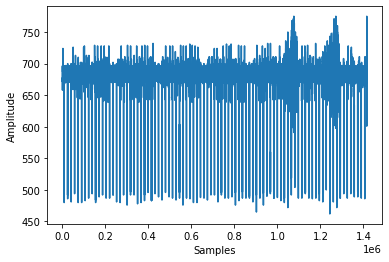

reading from file  dist_audio00.bin
ADC clock frequency (kHz)  1000.0
CPU clock frequency (kHz)  16000.0
ADC sample interval in CPU cycles  496
Arduino ADC analog pin recorded  7
Hit end of file, so exit the ADC data reading loop

All done. ADC data buffers read:  5454
ADC digitizations read:  1385060
this corresponds to  0.7213854166666667  minutes of recording


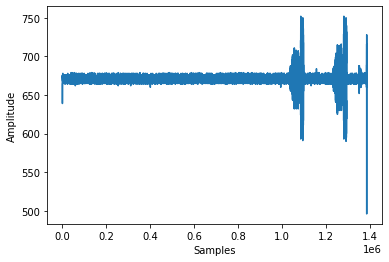

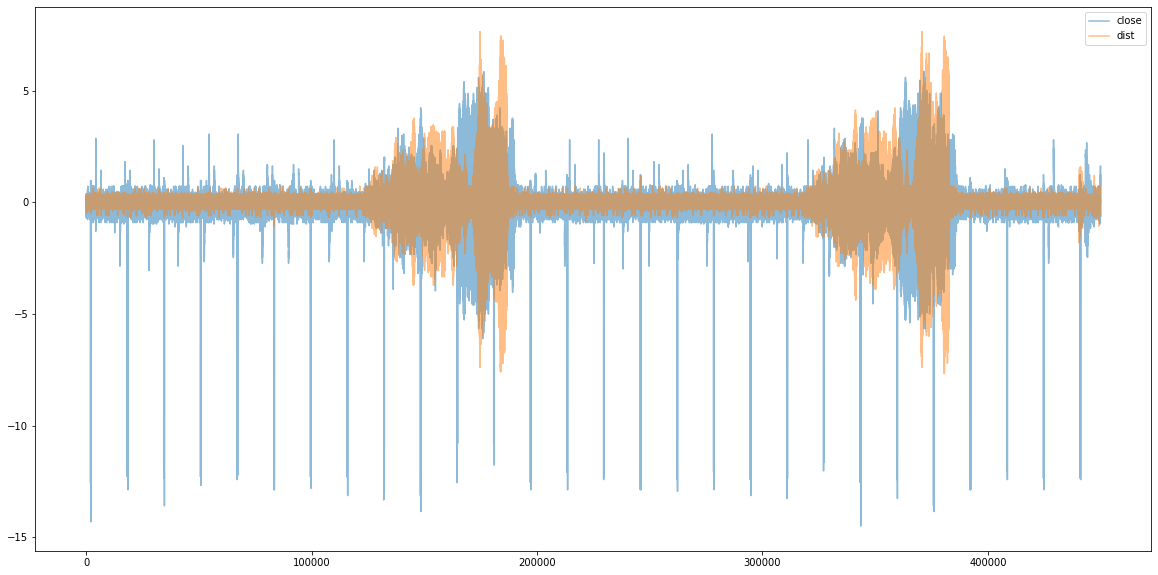

-50000 50000 50000 399999
min, max chisq:  1.7596071640718938 2.252792118519835
index shift for min, max:  -50000 -2000


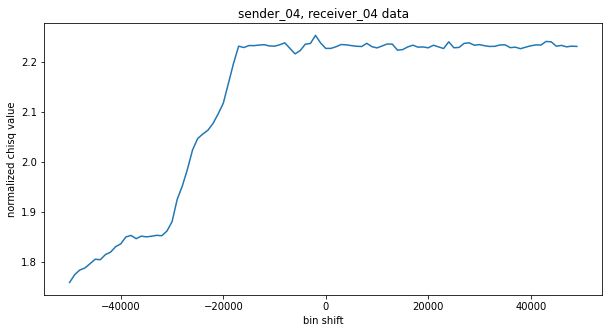

-55000 -45000 55000 450000
min, max chisq:  2.104863175459814 2.122245334017172
index shift for min, max:  -51500 -52300


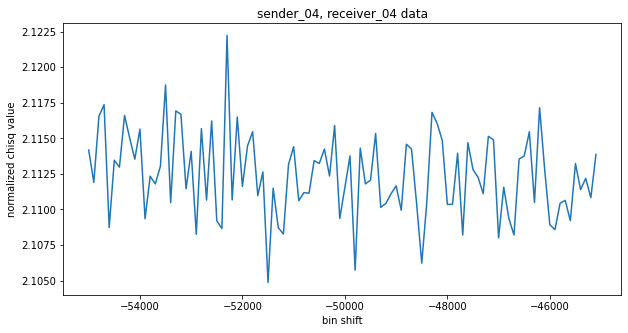

-52000 -51000 52000 450000
min, max chisq:  2.096654288920003 2.1143435039680742
index shift for min, max:  -51760 -51070


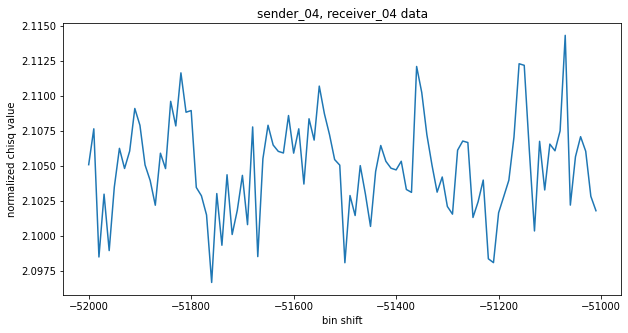

-51770 -51750 51770 450000
min, max chisq:  2.0939847738904644 2.103609550730783
index shift for min, max:  -51757 -51766


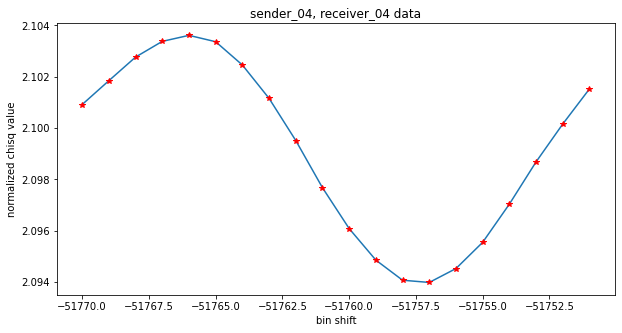

-51758 : 2.1018445384539817
-51757 : 2.102763598677548
-51756 : 2.103375330689218


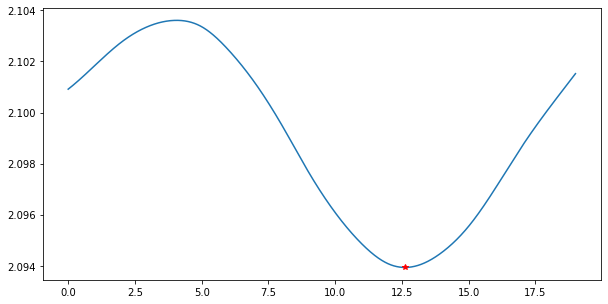

12.61
minimum bin shift: -51754.39 value: 2.0939343885633783
67270449828.0 67270591832.0
-142004.0
Delay is -1.4468286875 seconds


In [50]:
num = '00'
meta = '001'
senderFile = 'close_audio'+num+'.bin'
receiverFile = 'dist_audio'+num+'.bin' 
meta_send = 'close_met-'+meta+'.txt' 
meta_receive = 'dist_met-'+meta+'.txt' 
audtxt_send = 'close_aud-'+meta+'.txt'
audtxt_receive = 'dist_aud-'+meta+'.txt'
chi_square(senderFile, receiverFile, meta_send, meta_receive, audtxt_send, audtxt_receive, 
           int(9e5), int(9.1e5), int(4.5e5))

reading from file  sender_08.bin
ADC clock frequency (kHz)  1000.0
CPU clock frequency (kHz)  16000.0
ADC sample interval in CPU cycles  496
Arduino ADC analog pin recorded  7
Hit end of file, so exit the ADC data reading loop

All done. ADC data buffers read:  1402
ADC digitizations read:  355852
this corresponds to  0.1853395833333333  minutes of recording


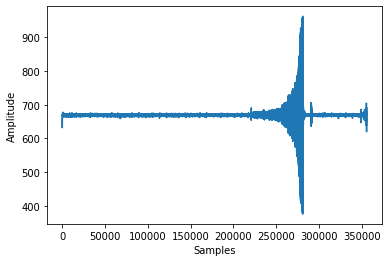

reading from file  receiver_08.bin
ADC clock frequency (kHz)  1000.0
CPU clock frequency (kHz)  16000.0
ADC sample interval in CPU cycles  496
Arduino ADC analog pin recorded  7
Hit end of file, so exit the ADC data reading loop

All done. ADC data buffers read:  1145
ADC digitizations read:  290574
this corresponds to  0.151340625  minutes of recording


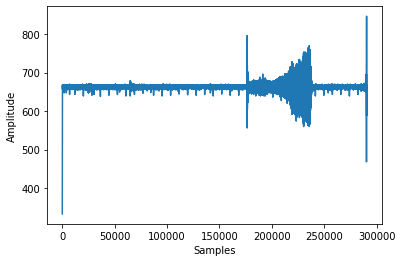

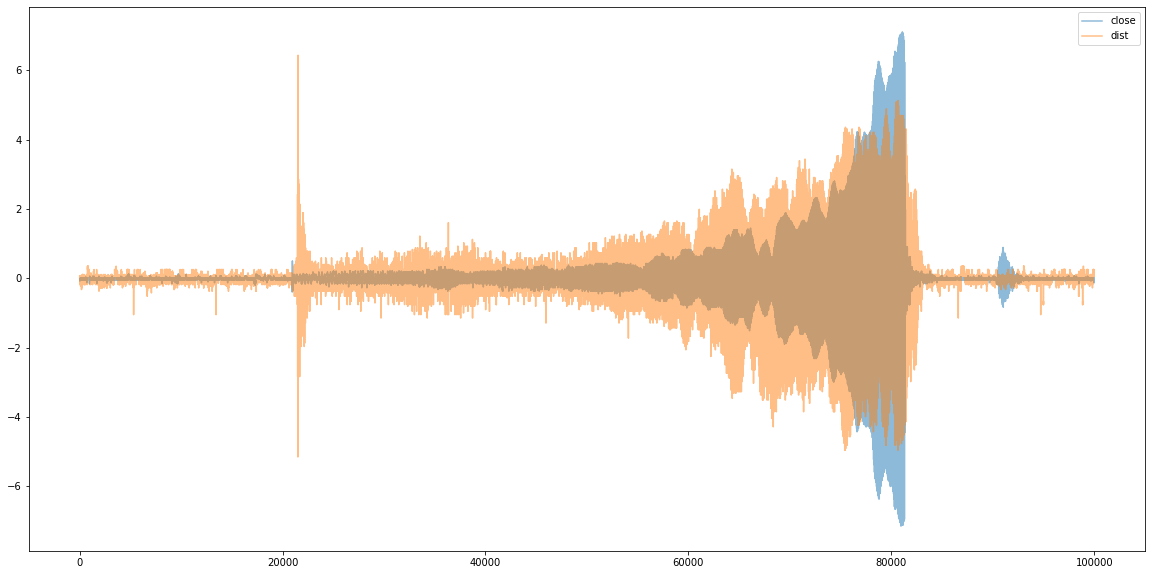

-5000 5000 5000 94999
min, max chisq:  0.8582747880492054 2.727451615980573
index shift for min, max:  700 600


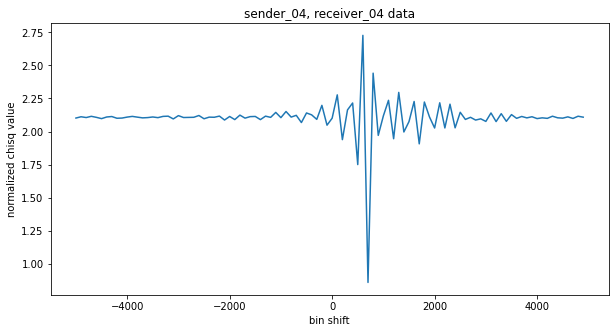

200 1200 0 98799
min, max chisq:  0.5203607679739644 3.596427537800901
index shift for min, max:  660 680


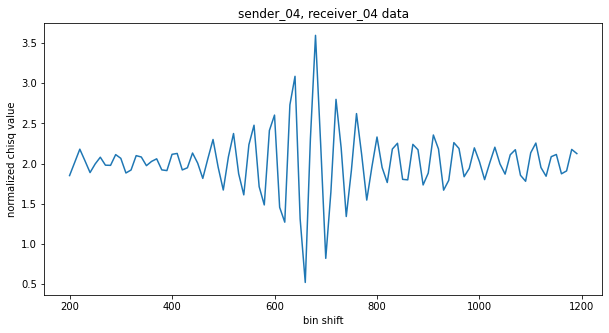

650 670 0 99329
min, max chisq:  0.4445593497395779 2.073965247219963
index shift for min, max:  658 669


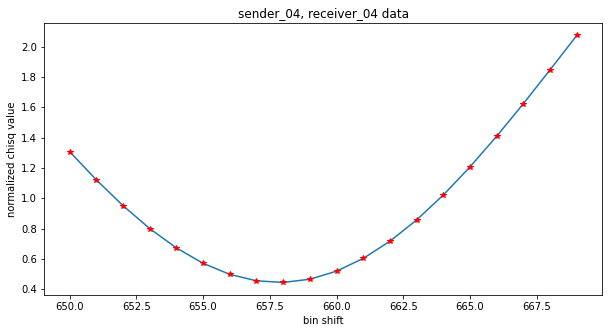

657 : 1.1216670145249124
658 : 0.95109811897684
659 : 0.8001722795723338


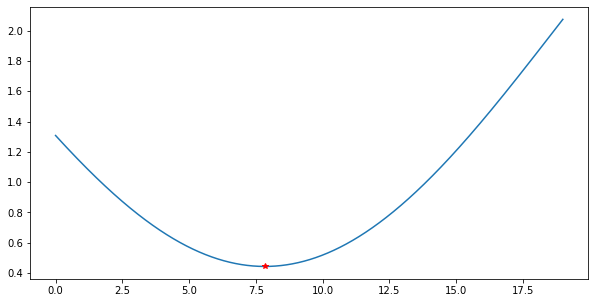

7.83
minimum bin shift: 655.83 value: 0.4441406215868872
13260311276.0 13258595164.0
1716112.0
Delay is 0.3303566875 seconds


In [36]:
num = '08'
meta = '08'
senderFile = 'sender_'+num+'.bin'
receiverFile = 'receiver_'+num+'.bin' 
meta_send = 'sender_met_'+meta+'.txt' 
meta_receive = 'receiver_met_'+meta+'.txt' 
audtxt_send = 'sender_aud_'+meta+'.txt'
audtxt_receive = 'receiver_aud_'+meta+'.txt'
chi_square(senderFile, receiverFile, meta_send, meta_receive, audtxt_send, audtxt_receive, 
           int(2e5), int(1.55e5), int(1e5))